In [1]:
from absl import logging
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [25]:
IMAGE_1_URL = 'https://science.nasa.gov/wp-content/uploads/2023/09/Milky_Way_illustration-1.jpeg?w=4096&format=jpeg'
IMAGE_2_URL = 'https://science.nasa.gov/wp-content/uploads/2023/06/spiral-galaxy-jpg.webp'

In [36]:
def download_and_resize(name, url, new_width=256, new_height=256):
  path = tf.keras.utils.get_file(name, url)
  image = Image.open(path)
  image = ImageOps.fit(image, (new_width, new_height), Image.ANTIALIAS)
  return image

139264/134433 [===============================] - 0s 2us/step


c:\Users\abiva\miniconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  after removing the cwd from sys.path.


262144/258603 [==============================] - 0s 1us/step


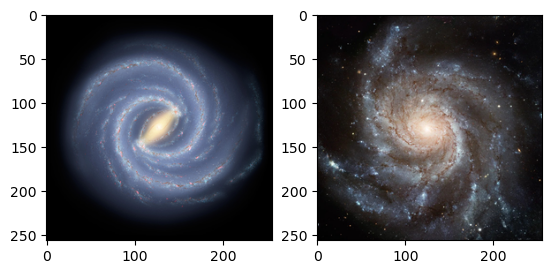

In [37]:
image1 = download_and_resize('image1.jpg', IMAGE_1_URL)
image2 = download_and_resize('image2.jpg', IMAGE_2_URL)

plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)

In [38]:
delf = hub.load('https://tfhub.dev/google/delf/1').signatures['default']

In [39]:
def run_delf(image):
  np_image = np.array(image)
  float_image = tf.image.convert_image_dtype(np_image, tf.float32)

  return delf(
      image=float_image,
      score_threshold=tf.constant(100.0),
      image_scales=tf.constant([0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0]),
      max_feature_num=tf.constant(1000))

In [40]:
result1 = run_delf(image1)
result2 = run_delf(image2)

In [41]:
def match_images(image1, image2, result1, result2):
  distance_threshold = 0.8

  # Read features.
  num_features_1 = result1['locations'].shape[0]
  print("Loaded image 1's %d features" % num_features_1)

  num_features_2 = result2['locations'].shape[0]
  print("Loaded image 2's %d features" % num_features_2)

  # Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(result1['descriptors'])
  _, indices = d1_tree.query(
      result2['descriptors'],
      distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
  locations_2_to_use = np.array([
      result2['locations'][i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])

  # Perform geometric verification using RANSAC.
  _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

  print('Found %d inliers' % sum(inliers))

  # Visualize correspondences.
  _, ax = plt.subplots()
  inlier_idxs = np.nonzero(inliers)[0]
  plot_matches(
      ax,
      image1,
      image2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
  ax.axis('off')
  ax.set_title('DELF correspondences')

Loaded image 1's 60 features
Loaded image 2's 23 features
Found 8 inliers


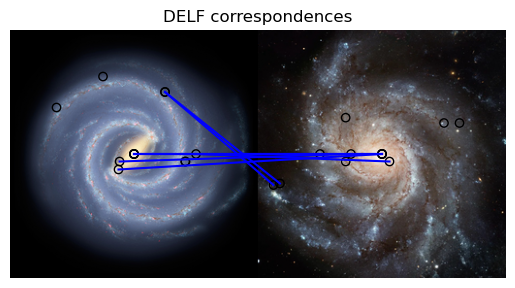

In [42]:
match_images(image1, image2, result1, result2)

In [43]:
import torch
from torchvision.models import resnet50
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names


In [44]:
x = torch.rand(1, 3, 224, 224)

model = resnet50()

return_nodes = {
    "layer3.5.relu_2": "layer3"
}
model2 = create_feature_extractor(model, return_nodes=return_nodes)
intermediate_outputs = model2(x)